In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import operator
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import file_utils    
import utils
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from pathlib import Path
from anytree import Node, RenderTree

%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
summary_team_file = '../Data/sr_summaries_kaggle_id_no_opp.csv'
team_meta_data_file = '../Data/D1_teams.csv'
tournament_data_file = '../Data/tournament_results_2018.csv'
rankings_data_file = '../Data/massey_seasons_with_id_2019.csv'

feature_dictionary = utils.Feature_Dictionary()

In [3]:
#Train using 2003 through 2018 tournament data corresponding to seasons 2002-2003 through 2017-2018
start_tournament = 2003
stop_tournament = 2018

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.
https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [4]:
# The season column in the summary data corresponds to the start year of the season
summary_data = file_utils.read_summary_team_data(summary_team_file)
tourney_teams_2018_2019_summary_data = summary_data[summary_data['season']== 2018]

# Train the model using seasons up to and including 2017-2018 
summary_data = summary_data[summary_data['season'] < stop_tournament]
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


In [5]:
tourney_teams_2018_2019_summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
6038,2018,Abilene Christian,a52b2ece-1f87-45b5-ae1e-8d0920479965,24,-2.21,-6.56,0.792,75,64,0.483,0.707,77.308333,10.0,22.0,12,8,97.014121,19
6039,2018,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,23,-4.74,0.35,0.435,67,71,0.457,0.682,75.008696,7.0,25.0,14,5,89.322977,16
6040,2018,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,23,5.78,-0.84,0.609,70,61,0.413,0.705,77.252174,10.0,26.0,11,5,90.612337,17
6041,2018,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,23,11.83,8.13,0.652,75,72,0.454,0.688,80.547826,11.0,26.0,13,4,93.112383,23
6042,2018,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,25,-18.19,-6.75,0.200,61,73,0.407,0.615,78.344000,9.0,22.0,15,7,77.861738,15


#### Read in the NCAA Men's Tournament.

In [6]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)

# The season year in the computer rankings file correspond to the tournament year (e.g. 2003 for 2002-2003 season)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

# Recoding the tourney data to generate team and opp_team fields to replace win and lose fields
# Also add a start season field to the tourney data for merging with summary data
tourney_data = utils.recode_tourney_data(tourney_data)

tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]

# Get the top conference list to use when predicting current tournament results
top_tournament_conferences = utils.get_tournament_top_conference_list(game_data)


In [7]:
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor
0,2003,64,2003-03-21 00:00:00.0000000,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,60,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,58,-1,2002,Lose,14.05,6.11,0.697,81.0,73.0,0.458,0.774,85.363636,11.0,24.0,15.0,7.0,94.888179,20.0,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0,Pacific 12,Pacific 12,30,43.0,33,36,32.0,42.0,29.0,27,38,31.0,25,34,20.0,37.0,33.0,66,0,0,0,8.0,6.0,2.0,0.007,1.0,1.0,0.063,8.0,8.0,0.0,-0.061,2.364814,2.0,-1,3.05,0.86,-8,12.0,8,2,12.0,5.0,-4.0,-39
1,2003,64,2003-03-21 00:00:00.0000000,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,85,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a,55,1,2002,Win,18.54,7.76,0.758,75.0,64.0,0.476,0.703,76.945455,10.0,24.0,13.0,7.0,97.471645,18.0,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0,Southeastern,Southland,7,11.0,11,10,14.0,6.0,8.0,7,138,102.0,115,143,87.0,134.0,93.0,169,1,0,1,11.0,7.0,4.0,0.017,-1.0,-1.0,-0.002,6.0,7.0,-1.0,-0.009,7.042104,-5.0,-13,20.19,14.63,-131,-91.0,-104,-133,-73.0,-128.0,-85.0,-162
2,2003,32,2003-03-23 00:00:00.0000000,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,68,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,62,-1,2002,Lose,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,Atlantic Coast,Southeastern,9,9.0,4,7,8.0,12.0,4.0,20,43,47.0,40,40,44.0,45.0,43.0,44,0,0,1,10.0,5.0,5.0,-0.012,2.0,3.0,0.092,9.0,8.0,1.0,0.159,4.598761,6.0,-8,4.28,-1.38,-34,-38.0,-36,-33,-36.0,-33.0,-39.0,-24
3,2003,64,2003-03-21 00:00:00.0000000,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,65,7,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8,63,1,2002,Win,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,14.61,3.71,0.767,70.0,59.0,0.443,0.686,75.666667,11.0,24.0,12.0,7.0,92.511013,20.0,Southeastern,Atlantic 10,43,47.0,40,40,44.0,45.0,43.0,44,20,16.0,27,28,27.0,18.0,22.0,38,1,0,0,5.0,11.0,-6.0,0.022,1.0,-1.0,-0.026,8.0,5.0,3.0,-0.120,-4.525801,0.0,3,-1.93,4.63,23,31.0,13,12,17.0,27.0,21.0,6
4,2003,4,2003-04-05 00:00:00.0000000,1,Texas,6ed15092-2670-450a-99c2-61d861e87644,95,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,84,-1,2002,Lose,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast,5,7.0,7,6,4.0,7.0,7.0,12,12,14.0,5,12,9.0,15.0,5.0,21,0,0,0,10.0,10.0,0.0,-0.029,3.0,-2.0,0.027,7.0,6.0,1.0,-0.069,-0.666215,1.0,-2,-0.11,0.25,-7,-7.0,2,-6,-5.0,-8.0,2.0,-9


In [8]:
tourney_comp_ratings.describe()

,season_t,round,seed_t,win_pts,seed_o,lose_pts,game_result,start_season,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor
count,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000
mean,2010.607656,44.210526,7.087081,75.135885,6.845933,63.734928,-0.000957,2009.607656,14.028335,5.530660,0.744365,73.857416,64.950239,0.460840,0.707440,77.899113,11.133971,23.879426,12.097608,6.520574,94.843805,20.910048,14.265703,5.644019,0.746697,73.882297,64.856459,0.461457,0.708194,77.927647,11.177033,23.975120,12.117703,6.457416,94.852399,20.956938,41.624880,39.409569,38.815311,43.102392,38.729187,41.668900,39.401914,43.454545,39.546411,37.558852,37.019139,40.934928,36.905263,39.953110,37.828708,41.761722,0.241148,0.238278,0.475598,8.907177,9.025837,-0.118660,-0.000617,-0.043062,-0.095694,-0.000754,5.577033,5.660287,-0.083254,-0.002332,-0.008594,-0.046890,0.241148,-0.237368,-0.113359,2.078469,1.850718,1.796172,2.167464,1.823923,1.715789,1.573206,1.692823
std,4.607293,22.442470,4.697668,10.754252,4.658675,10.357664,1.000478,4.607293,7.581008,4.758944,0.096800,5.243657,4.654069,0.022487,0.035885,4.384704,1.842257,2.135453,1.671271,1.340787,4.779402,2.620203,7.485940,4.774284,0.097354,5.043729,4.667741,0.021874,0.034975,4.378116,1.849264,2.198779,1.708252,1.376233,4.658676,2.761091,50.993022,47.266513,45.542046,53.712143,45.150243,50.249926,47.383808,52.664767,49.902942,46.881399,45.526692,52.477523,44.985094,49.892247,47.205899,51.707100,0.427985,0.426234,0.499643,4.243543,4.229787,6.113963,0.031684,2.540300,2.553720,0.050656,1.851025,1.794095,2.500911,0.137027,6.456617,3.629211,7.464683,11.096737,6.884305,69.523609,64.192081,61.678327,73.700633,61.313728,69.249290,64.041127,73.124929
min,2003.000000,2.000000,1.000000,47.000000,1.000000,29.000000,-1.000000,2002.000000,-14.510000,-12.120000,0.406000,59.000000,51.000000,0.380000,0.591000,62.412903,5.000000,17.000000,7.000000,3.000000,76.996634,13.000000,-15.280000,-12.860000,0.412000,59.000000,50.000000,0.394000,0.612000,59.144828,5.000000,15.000000,7.000000,3.000000,79.371255,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-7.000000,-6.000000,-21.000000,-0.094000,-8.000000,-9.000000,-0.163000,0.000000,0.000000,-7.000000,-0.493000,-21.932677,-10.000000,-15.000000,-36.970000,-19

In [9]:
model_features = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg', 'delta_def_rebs_avg', 'delta_to_net_avg', 
                  'delta_win_pct', 'delta_off_rating', 'delta_ft_att_avg', 'delta_seed', 'delta_srs', 
                  'delta_sos', 'delta_sag', 'delta_wlk', 'delta_wol', 'delta_rth', 
                  'delta_col', 'delta_pom', 'delta_dol', 'delta_mor', 'top_conf_t', 'top_conf_o']

In [10]:
numeric_features = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg', 'delta_def_rebs_avg', 'delta_to_net_avg', 
                    'delta_win_pct', 'delta_off_rating', 'delta_ft_att_avg', 'delta_seed', 'delta_srs', 
                    'delta_sos', 'delta_sag', 'delta_wlk', 'delta_wol', 'delta_rth', 
                    'delta_col', 'delta_pom', 'delta_dol', 'delta_mor']

# Convert types to float to eliminate needless scaler warning 
for item in numeric_features:
    tourney_comp_ratings[item] = tourney_comp_ratings[item].astype(float)


In [11]:
feature_columns = numeric_features  + ['season_t', 'top_conf_t', 'top_conf_o']
feature_data = tourney_comp_ratings[feature_columns].copy()
feature_data.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,season_t,top_conf_t,top_conf_o
0,2.0,0.007,1.0,1.0,0.0,-0.061,2.364814,2.0,-1.0,3.05,0.86,-8.0,12.0,8.0,2.0,12.0,5.0,-4.0,-39.0,2003,0,0
1,4.0,0.017,-1.0,-1.0,-1.0,-0.009,7.042104,-5.0,-13.0,20.19,14.63,-131.0,-91.0,-104.0,-133.0,-73.0,-128.0,-85.0,-162.0,2003,1,0
2,5.0,-0.012,2.0,3.0,1.0,0.159,4.598761,6.0,-8.0,4.28,-1.38,-34.0,-38.0,-36.0,-33.0,-36.0,-33.0,-39.0,-24.0,2003,0,0
3,-6.0,0.022,1.0,-1.0,3.0,-0.120,-4.525801,0.0,3.0,-1.93,4.63,23.0,31.0,13.0,12.0,17.0,27.0,21.0,6.0,2003,1,0
4,0.0,-0.029,3.0,-2.0,1.0,-0.069,-0.666215,1.0,-2.0,-0.11,0.25,-7.0,-7.0,2.0,-6.0,-5.0,-8.0,2.0,-9.0,2003,0,0


In [12]:
X= feature_data[feature_data['season_t']<= stop_tournament]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['game_result']

X.describe()


,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,season_t,top_conf_t,top_conf_o
count,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000
mean,-0.118660,-0.000617,-0.043062,-0.095694,-0.083254,-0.002332,-0.008594,-0.046890,0.241148,-0.237368,-0.113359,2.078469,1.850718,1.796172,2.167464,1.823923,1.715789,1.573206,1.692823,2010.607656,0.241148,0.238278
std,6.113963,0.031684,2.540300,2.553720,2.500911,0.137027,6.456617,3.629211,7.464683,11.096737,6.884305,69.523609,64.192081,61.678327,73.700633,61.313728,69.249290,64.041127,73.124929,4.607293,0.427985,0.426234
min,-21.000000,-0.094000,-8.000000,-9.000000,-7.000000,-0.493000,-21.932677,-10.000000,-15.000000,-36.970000,-19.570000,-309.000000,-282.000000,-283.000000,-310.000000,-257.000000,-318.000000,-293.000000,-302.000000,2003.000000,0.000000,0.000000
25%,-4.000000,-0.023000,-2.000000,-2.000000,-2.000000,-0.091000,-4.499795,-2.000000,-5.000000,-6.490000,-3.870000,-24.000000,-22.000000,-22.000000,-25.000000,-24.000000,-25.000000,-23.000000,-25.000000,2007.000000,0.000000,0.000000
50%,0.000000,-0.001000,0.000000,0.000000,0.000000,0.000000,0.148123,0.000000,0.000000,-0.220000,-0.220000,1.000000,1.000000,2.000000,2.000000,1.000000,-1.000000,1.000000,1.000000,2011.000000,0.000000,0.000000
75%,4.000000,0.021000,2.000000,2.000000,2.000000,0.086000,4.112294,2.000000,7.000000,5.930000,3.260000,28.000000,26.000000,26.000000,29.000000,26.000000,27.000000,25.000000,30.000000,2015.000000,0.000000,0.000000
max,22.000000,0.109000,9.000000,9.000000,8.000000,0.560000,19.316619,12.000000,15.000000,36.990000,21.640000,265.000000,248.000000,251.000000,289.000000,256.000000,249.000000,266.000000,267.000000,2018.000000,1.000000,1.000000


In [58]:
y

0      -1
1       1
2      -1
3       1
4      -1
5       1
6      -1
7       1
8      -1
9       1
10     -1
11      1
12     -1
13      1
14     -1
15      1
16     -1
17      1
18     -1
19      1
20     -1
21      1
22     -1
23      1
24     -1
25      1
26     -1
27      1
28     -1
29      1
       ..
1018   -1
1019    1
1020   -1
1021    1
1022   -1
1023    1
1024   -1
1025    1
1026   -1
1027    1
1028   -1
1029    1
1030   -1
1031    1
1032   -1
1033    1
1034   -1
1035    1
1036   -1
1037    1
1038   -1
1039    1
1040   -1
1041    1
1042   -1
1043    1
1044   -1
1045    1
1046   -1
1047    1
Name: game_result, Length: 1045, dtype: int64

In [13]:
X= X.drop(columns=['season_t'])

In [14]:
X.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,top_conf_t,top_conf_o
0,2.0,0.007,1.0,1.0,0.0,-0.061,2.364814,2.0,-1.0,3.05,0.86,-8.0,12.0,8.0,2.0,12.0,5.0,-4.0,-39.0,0,0
1,4.0,0.017,-1.0,-1.0,-1.0,-0.009,7.042104,-5.0,-13.0,20.19,14.63,-131.0,-91.0,-104.0,-133.0,-73.0,-128.0,-85.0,-162.0,1,0
2,5.0,-0.012,2.0,3.0,1.0,0.159,4.598761,6.0,-8.0,4.28,-1.38,-34.0,-38.0,-36.0,-33.0,-36.0,-33.0,-39.0,-24.0,0,0
3,-6.0,0.022,1.0,-1.0,3.0,-0.120,-4.525801,0.0,3.0,-1.93,4.63,23.0,31.0,13.0,12.0,17.0,27.0,21.0,6.0,1,0
4,0.0,-0.029,3.0,-2.0,1.0,-0.069,-0.666215,1.0,-2.0,-0.11,0.25,-7.0,-7.0,2.0,-6.0,-5.0,-8.0,2.0,-9.0,0,0


#### Scale the input data.
Note the input sets are scaled independently to prevent data snooping.

In [15]:
scaler =StandardScaler(copy=True, with_mean=True, with_std=True)

scaler.fit(X[numeric_features])
X[numeric_features]= scaler.transform(X[numeric_features])


In [18]:
X.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,top_conf_t,top_conf_o
0,0.346694,0.240524,0.410802,0.429263,0.033305,-0.428353,0.367769,0.564274,-0.166349,0.296388,0.141456,-0.145034,0.158184,0.100632,-0.002273,0.166047,0.047449,-0.087067,-0.556750,0,0
1,0.673971,0.556288,-0.376883,-0.354283,-0.366740,-0.048685,1.092534,-1.365443,-1.774689,1.841726,2.142615,-1.915064,-1.447144,-1.716111,-1.834885,-1.220930,-1.874068,-1.352485,-2.239608,1,0
2,0.837609,-0.359427,0.804645,1.212810,0.433351,1.177935,0.713928,1.666970,-1.104547,0.407285,-0.184078,-0.519187,-0.621102,-0.613088,-0.477395,-0.617187,-0.501556,-0.633853,-0.351523,0,0
3,-0.962413,0.714170,0.410802,-0.354283,1.233442,-0.859130,-0.699959,0.012926,0.369764,-0.152607,0.689340,0.301071,0.454312,0.181736,0.133476,0.247634,0.365294,0.303494,0.058930,1,0
4,0.019417,-0.896225,1.198488,-0.746056,0.433351,-0.486763,-0.101901,0.288600,-0.300377,0.011484,0.052806,-0.130644,-0.137945,0.003306,-0.110873,-0.111348,-0.140369,0.006668,-0.146297,0,0


#### Train Model 

In [19]:
logreg = LogisticRegression(solver='liblinear')

result = logreg.fit(X,y)

print("Coeffs ",logreg.coef_)
print("Intercept ", logreg.intercept_)

Coeffs  [[-0.90195529  0.01335487  0.01079129 -0.06021268 -0.11302271  3.66778722
  -0.09806244 -0.15147156  1.56335971  2.53737606  3.40173869  0.03433412
  -0.72242211 -1.16295184  1.49421836  2.20530454  0.29610066  2.03039569
  -0.37496708  0.14883261 -0.08867611]]
Intercept  [-0.0169379]


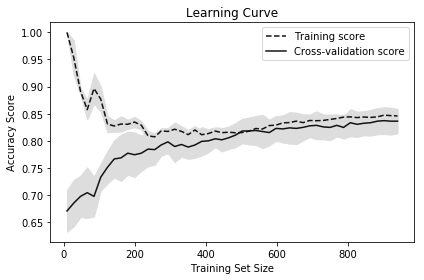

In [20]:
train_sizes, train_scores, test_scores = learning_curve(logreg, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Run Model Against (Projected) 2018-2019 Season Tournament

In [204]:
class TournamentBracket:

    def build_bracket(self, section):
        nodes = []

        # leaf nodes
        for i in range(16):
            label = 'l_16_' + str(i)
            seed_value = self.index_to_seed[i]
            team_name = section.loc[section.seed == seed_value, 'team'].to_list()[0]
            team_id = section.loc[section.seed == seed_value, 'id'].to_list()[0]
            nodes.append(Node(label, team=team_name, team_id=team_id, seed=seed_value))

        # 2nd level of 8 nodes
        child_index = 0
        for i in range(16, 24):
            node = Node('l_8_' + str(i - 15), team='', team_id='', seed='')
            node.children = [nodes[child_index], nodes[child_index + 1]]
            nodes.append(node)
            child_index += 2

        # 3rd level of 4 nodes
        child_index = 16
        for i in range(24, 28):
            node = Node('l_4_' + str(i - 23), team='', team_id='', seed='')
            node.children = [nodes[child_index], nodes[child_index + 1]]
            nodes.append(node)
            child_index += 2

        # 4th level of 2 nodes
        child_index = 24
        for i in range(28, 30):
            node = Node('l_2_' + str(i - 27), team='', team_id='', seed='')
            node.children = [nodes[child_index], nodes[child_index + 1]]
            nodes.append(node)
            child_index += 2

        root_node = Node('ROOT', team='', team_id='', seed='')
        root_node.children = [nodes[28], nodes[29]]
        nodes.append(root_node)
        return nodes

    def __init__(self):

        self.index_to_seed = {0: 1, 1: 16, 2: 8, 3: 9, 4: 5, 5: 12, 6: 4, 7: 13, 8: 6, 9: 11,
                              10: 3, 11: 14, 12: 7, 13: 10, 14: 2, 15: 15}

        # Read file with tournament teams
        teams_file = "../Data/teams_2019.csv"
        self.tournament_teams = pd.read_csv(Path(teams_file))

        self.east_section = self.tournament_teams[self.tournament_teams['quadrant'] == 'East']
        self.east_nodes = self.build_bracket(self.east_section)

        self.midwest_section = self.tournament_teams[self.tournament_teams['quadrant'] == 'Midwest']
        self.midwest_nodes = self.build_bracket(self.midwest_section)

        self.south_section = self.tournament_teams[self.tournament_teams['quadrant'] == 'South']
        self.south_nodes = self.build_bracket(self.south_section)

        self.west_section = self.tournament_teams[self.tournament_teams['quadrant'] == 'West']
        self.west_nodes = self.build_bracket(self.west_section)
        
        self.west_winner= None
        self.midwest_winner = None
        self.east_winner = None
        self.south_winner = None

        return
    
    def set_team_conferences(self, team_conferences):
        self.team_conferences = team_conferences
        
    def set_top_tournament_conferences(self, top_tournament_conferences):
        self.top_tournament_conferences = top_tournament_conferences
        
    def set_model_features(self, model_features):
        self.model_features = model_features
        
    def set_numeric_features(self, numeric_features):
        self.numeric_features = numeric_features
        
    def set_scaler(self, scaler):
        self.scaler = scaler
        
    def set_classifier(self, classifier):
        self.classifier = classifier
        
    def set_summary_data(self, summary_data):
        self.summary_data = summary_data
        
    def predict_winning_team(self, t1, t2):
        team_t = get_team_record(self.summary_data, t1.team_id, t1.seed, False)
        team_opp = get_team_record(self.summary_data, t2.team_id, t2.seed, True)
        game_record_df = pd.concat([team_t ,team_opp], axis=1, sort=False)
        delta_game_record = utils.compute_delta_features(game_record_df)
    
        t1_top,t2_top = compute_top_conference_values(self.team_conferences, self.top_tournament_conferences, delta_game_record)
    
        delta_game_record['top_conf_t'] = t1_top
        delta_game_record['top_conf_o'] = t2_top
    
        prediction_record = delta_game_record[model_features].copy()
    
        for item in self.numeric_features:
            prediction_record[item] = prediction_record[item].astype(float)
        
        prediction_record[self.numeric_features] = self.scaler.transform(prediction_record[self.numeric_features])
    
        y_predict = self.classifier.predict(prediction_record)
        #  print("y_predict= ", y_predict[0])
    
        if y_predict[0] == 1:
            return t1.team, t1.team_id
        else:
            return t2.team, t2.team_id
        

    def display_east_section(self):
        for pre, _, node in RenderTree(self.east_nodes[30]):
            print("%s(%s) %s" % (pre, node.seed, node.team))
        return

    def display_midwest_section(self):
        for pre, _, node in RenderTree(self.midwest_nodes[30]):
            print("%s(%s) %s" % (pre, node.seed, node.team))
        return

    def display_south_section(self):
        for pre, _, node in RenderTree(self.south_nodes[30]):
            print("%s(%s) %s" % (pre, node.seed, node.team))
        return

    def display_west_section(self):
        for pre, _, node in RenderTree(self.west_nodes[30]):
            print("%s(%s) %s" % (pre, node.seed, node.team))
        return

    def build_final_four(self):
        self.s1_node = Node('semi_east_west',team='', team_id='', seed='')
        self.east_winner.parent = self.s1_node
        self.west_winner.parent = self.s1_node
        self.east_winner.children= []
        self.west_winner.children= []
        
        self.s2_node = Node('semi_south_midwest', team='', team_id='', seed='')
        self.south_winner.parent = self.s2_node
        self.midwest_winner.parent = self.s2_node
        self.south_winner.children= []
        self.midwest_winner.children= []
        
        self.winning_node = Node('tourney_winner',team='', team_id='', seed='')
        self.winning_node.children = [self.s1_node, self.s2_node]
        self.winning_node.parent=None
        
        self.display_final_four()
        return
    
    def display_final_four(self):
        for pre, _, node in RenderTree(self.winning_node):
            print("%s(%s) %s" % (pre, node.seed, node.team))
        return
        
        
    def tree_eval(self, node, debug=False):

        if debug:
            print('Node Team:', node.team)
        
        if not node.is_leaf:
            children = list(node.children)
            if debug:
                for child in children:
                    print(child)

            t1 = self.tree_eval(children[0])
            t2 = self.tree_eval(children[1])
            team, team_id = self.predict_winning_team(t1, t2)
            node.team = team
            node.team_id = team_id
            if team == t1.team:
                node.seed = t1.seed
            else:
                node.seed = t2.seed
                
        return node

    def eval_east_section(self):
        result = self.tree_eval(self.east_nodes[30])
        self.east_winner = result
        return result.team, result.team_id, result.seed
    
    def eval_west_section(self):
        result = self.tree_eval(self.west_nodes[30])
        self.west_winner = result
        return result.team, result.team_id, result.seed
    
    def eval_midwest_section(self):
        result = self.tree_eval(self.midwest_nodes[30])
        self.midwest_winner = result
        return result.team, result.team_id, result.seed
    
    def eval_south_section(self):
        result = self.tree_eval(self.south_nodes[30])
        self.south_winner = result
        return result.team, result.team_id, result.seed
    
    def eval_final_four(self):
        result = self.tree_eval(self.winning_node, True)
        return result.team, result.team_id, result.seed

In [61]:
def compute_top_conference_values(team_conferences, top_tournament_conferences, delta_game_record):
    t1_id = delta_game_record.iloc[0]['team_id_t']
    t2_id = delta_game_record.iloc[0]['team_id_o']
    t1_conference = team_conferences[team_conferences['id']== t1_id]['conf_name'].values[0]
    t2_conference = team_conferences[team_conferences['id']== t2_id]['conf_name'].values[0]
    # if both teams in same conference return 0,0 - no advantage
    if t1_conference == t2_conference:
        return 0,0
    t1_top_conference = t1_conference in top_tournament_conferences
    t2_top_conference = t2_conference in top_tournament_conferences
    if t1_top_conference == t2_top_conference:
        # both teams in or out of a top conference
        return 0,0 
    if t1_top_conference:
        return 1,0
    else:
        return 0,1

In [62]:
def get_team_record(summary_data_with_rankings, team_id, seed, is_opposition):
    team = summary_data_with_rankings[summary_data_with_rankings['team_id'] == team_id].copy()
    team['seed'] = seed
    if is_opposition:
        team = team.rename(columns={'season':'season_o','school':'school_o', 'team_id':'team_id_o', 'srs':'srs_o', 
                                    'sos':'sos_o','win_pct':'win_pct_o', 'pts_avg':'pts_avg_o', 
                                    'opp_pts_avg':'opp_pts_avg_o', 'fg_pct': 'fg_pct_o', 'ft_pct':'ft_pct_o', 
                                    'poss_avg':'poss_avg_o', 'off_rebs_avg':'off_rebs_avg_o', 'def_rebs_avg':'def_rebs_avg_o',
                                    'to_avg':'to_avg_o','steal_avg':'steal_avg_o','off_rating':'off_rating_o',
                                    'ft_att_avg':'ft_att_avg_o', 'SAG':'sag_o','WLK':'wlk_o','WOL':'wol_o',
                                    'RTH':'rth_o','COL':'col_o','POM':'pom_o','DOL':'dol_o','MOR':'mor_o','seed':'seed_o'})
    else:
        team = team.rename(columns={'season':'season_t','school':'school_t', 'team_id':'team_id_t', 'srs':'srs_t',
                                    'sos':'sos_t','win_pct':'win_pct_t', 'pts_avg':'pts_avg_t', 'opp_pts_avg':'opp_pts_avg_t',
                                    'fg_pct': 'fg_pct_t', 'ft_pct':'ft_pct_t', 'poss_avg':'poss_avg_t', 
                                    'off_rebs_avg':'off_rebs_avg_t', 'def_rebs_avg':'def_rebs_avg_t', 'to_avg':'to_avg_t',
                                    'steal_avg':'steal_avg_t','off_rating':'off_rating_t', 'ft_att_avg':'ft_att_avg_t', 
                                    'SAG':'sag_t','WLK':'wlk_t','WOL':'wol_t','RTH':'rth_t','COL':'col_t','POM':'pom_t', 
                                    'DOL':'dol_t','MOR':'mor_t','seed':'seed_t'}) 
        
    team = team.reset_index(drop=True)
    
    return team           

In [64]:
tourney_teams_2018_2019_summary_data['tourney_season'] = 2019
tourney_teams_2018_2019_summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg,tourney_season
6038,2018,Abilene Christian,a52b2ece-1f87-45b5-ae1e-8d0920479965,24,-2.21,-6.56,0.792,75,64,0.483,0.707,77.308333,10.0,22.0,12,8,97.014121,19,2019
6039,2018,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,23,-4.74,0.35,0.435,67,71,0.457,0.682,75.008696,7.0,25.0,14,5,89.322977,16,2019
6040,2018,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,23,5.78,-0.84,0.609,70,61,0.413,0.705,77.252174,10.0,26.0,11,5,90.612337,17,2019
6041,2018,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,23,11.83,8.13,0.652,75,72,0.454,0.688,80.547826,11.0,26.0,13,4,93.112383,23,2019
6042,2018,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,25,-18.19,-6.75,0.200,61,73,0.407,0.615,78.344000,9.0,22.0,15,7,77.861738,15,2019


In [65]:
computer_rankings_2019 = computer_rankings[computer_rankings['season'] == 2019]
computer_rankings_2019.head(10)

,SAG,WLK,WOL,Team,RTH,COL,POM,DOL,MOR,season,win_pct,kaggle_id
5457,1,1.0,1,Duke,1,1.0,1.0,1.0,2,2019,0.913043,faeb1160-5d15-4f26-99fc-c441cf21fc7f
5458,2,3.0,4,Gonzaga,4,8.0,3.0,5.0,1,2019,0.920000,2f4d21f8-6d5f-48a5-abca-52a30583871a
5459,3,2.0,3,Virginia,2,5.0,2.0,2.0,3,2019,0.909091,56913910-87f7-4ad7-ae3b-5cd9fb218fd9
5460,7,5.0,2,Tennessee,3,2.0,5.0,3.0,6,2019,0.956522,b827dbdf-230f-4916-9703-3bb9004e26eb
5461,6,7.0,7,Kentucky,6,7.0,7.0,6.0,8,2019,0.869565,2267a1f4-68f6-418b-aaf6-2aa0c4b291f1
5462,9,8.0,6,Michigan,5,3.0,6.0,4.0,9,2019,0.916667,bdc2561d-f603-4fab-a262-f1d2af462277
5463,5,4.0,11,Michigan St,9,13.0,4.0,9.0,4,2019,0.791667,a41d5a05-4c11-4171-a57e-e7a1ea325a6d
5464,4,6.0,9,North Carolina,7,9.0,8.0,7.0,5,2019,0.826087,e9ca48b2-00ba-41c0-a02b-6885a2da1ff1
5465,8,9.0,14,Purdue,11,16.0,9.0,12.0,7,2019,0.739130,12d7f888-675b-459f-9099-a38f771d8a95
5466,13,17.0,8,Nevada,20,11.0,17.0,10.0,10,2019,0.958333,62a73b4a-e281-4483-a1f8-f1160a18e456


In [79]:
# Combine summary data with computer ranking data
summary_data_with_rankings = tourney_teams_2018_2019_summary_data.merge(computer_rankings_2019, 
                                                                        left_on=['tourney_season','team_id'], 
                                                                        right_on=['season','kaggle_id'], how='left',
                                                                        suffixes=('','_y'))

summary_data_with_rankings.drop(columns=['season_y', 'win_pct_y', 'kaggle_id','Team','games','tourney_season'], inplace=True)
summary_data_with_rankings.head()

,season,school,team_id,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg,SAG,WLK,WOL,RTH,COL,POM,DOL,MOR
0,2018,Abilene Christian,a52b2ece-1f87-45b5-ae1e-8d0920479965,-2.21,-6.56,0.792,75,64,0.483,0.707,77.308333,10.0,22.0,12,8,97.014121,19,187.0,154.0,120.0,161.0,123.0,164.0,132.0,209.0
1,2018,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,-4.74,0.35,0.435,67,71,0.457,0.682,75.008696,7.0,25.0,14,5,89.322977,16,230.0,236.0,279.0,238.0,219.0,258.0,222.0,241.0
2,2018,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5.78,-0.84,0.609,70,61,0.413,0.705,77.252174,10.0,26.0,11,5,90.612337,17,127.0,127.0,145.0,131.0,143.0,100.0,147.0,128.0
3,2018,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,11.83,8.13,0.652,75,72,0.454,0.688,80.547826,11.0,26.0,13,4,93.112383,23,44.0,43.0,45.0,41.0,45.0,46.0,44.0,49.0
4,2018,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,-18.19,-6.75,0.200,61,73,0.407,0.615,78.344000,9.0,22.0,15,7,77.861738,15,349.0,346.0,337.0,339.0,341.0,344.0,343.0,342.0


In [205]:
bracket =TournamentBracket()

bracket.set_team_conferences(teams.reset_index())
bracket.set_top_tournament_conferences(top_tournament_conferences)
bracket.set_model_features(model_features)
bracket.set_numeric_features(numeric_features)
bracket.set_scaler(scaler)
bracket.set_classifier(logreg)
bracket.set_summary_data(summary_data_with_rankings)

In [206]:
print('East Section')
bracket.display_east_section()

East Section
() 
├── () 
│   ├── () 
│   │   ├── () 
│   │   │   ├── (1) Duke
│   │   │   └── (16) Bucknell
│   │   └── () 
│   │       ├── (8) Washington
│   │       └── (9) Ohio St.
│   └── () 
│       ├── () 
│       │   ├── (5) Iowa St.
│       │   └── (12) Temple
│       └── () 
│           ├── (4) LSU
│           └── (13) Murray St.
└── () 
    ├── () 
    │   ├── () 
    │   │   ├── (6) Florida St.
    │   │   └── (11) Minnesota
    │   └── () 
    │       ├── (3) Marquette
    │       └── (14) Old Dominion
    └── () 
        ├── () 
        │   ├── (7) Buffalo
        │   └── (10) Alabama
        └── () 
            ├── (2) Michigan St.
            └── (15) Loyola Chicago


In [207]:
win_team, win_team_id, win_seed = bracket.eval_east_section()
print('East Section')
bracket.display_east_section()

East Section
(1) Duke
├── (1) Duke
│   ├── (1) Duke
│   │   ├── (1) Duke
│   │   │   ├── (1) Duke
│   │   │   └── (16) Bucknell
│   │   └── (8) Washington
│   │       ├── (8) Washington
│   │       └── (9) Ohio St.
│   └── (4) LSU
│       ├── (5) Iowa St.
│       │   ├── (5) Iowa St.
│       │   └── (12) Temple
│       └── (4) LSU
│           ├── (4) LSU
│           └── (13) Murray St.
└── (2) Michigan St.
    ├── (6) Florida St.
    │   ├── (6) Florida St.
    │   │   ├── (6) Florida St.
    │   │   └── (11) Minnesota
    │   └── (3) Marquette
    │       ├── (3) Marquette
    │       └── (14) Old Dominion
    └── (2) Michigan St.
        ├── (7) Buffalo
        │   ├── (7) Buffalo
        │   └── (10) Alabama
        └── (2) Michigan St.
            ├── (2) Michigan St.
            └── (15) Loyola Chicago


In [208]:
print('West Section')
bracket.display_west_section()

West Section
() 
├── () 
│   ├── () 
│   │   ├── () 
│   │   │   ├── (1) Gonzaga
│   │   │   └── (16) Prairie View
│   │   └── () 
│   │       ├── (8) Syracuse
│   │       └── (9) Texas   
│   └── () 
│       ├── () 
│       │   ├── (5) Villanova
│       │   └── (12) Hofstra
│       └── () 
│           ├── (4) Louisville
│           └── (13) Vermont
└── () 
    ├── () 
    │   ├── () 
    │   │   ├── (6) Iowa
    │   │   └── (11) UCF
    │   └── () 
    │       ├── (3) Houston
    │       └── (14) UC Irvine
    └── () 
        ├── () 
        │   ├── (7) Mississippi St.
        │   └── (10) Clemson
        └── () 
            ├── (2) Michigan
            └── (15) Montana


In [209]:
win_team, win_team_id, win_seed = bracket.eval_west_section()
bracket.display_west_section()

(2) Michigan
├── (1) Gonzaga
│   ├── (1) Gonzaga
│   │   ├── (1) Gonzaga
│   │   │   ├── (1) Gonzaga
│   │   │   └── (16) Prairie View
│   │   └── (8) Syracuse
│   │       ├── (8) Syracuse
│   │       └── (9) Texas   
│   └── (5) Villanova
│       ├── (5) Villanova
│       │   ├── (5) Villanova
│       │   └── (12) Hofstra
│       └── (4) Louisville
│           ├── (4) Louisville
│           └── (13) Vermont
└── (2) Michigan
    ├── (3) Houston
    │   ├── (6) Iowa
    │   │   ├── (6) Iowa
    │   │   └── (11) UCF
    │   └── (3) Houston
    │       ├── (3) Houston
    │       └── (14) UC Irvine
    └── (2) Michigan
        ├── (10) Clemson
        │   ├── (7) Mississippi St.
        │   └── (10) Clemson
        └── (2) Michigan
            ├── (2) Michigan
            └── (15) Montana


In [210]:
print('Midwest Section')
bracket.display_midwest_section()

Midwest Section
() 
├── () 
│   ├── () 
│   │   ├── () 
│   │   │   ├── (1) Virginia
│   │   │   └── (16) Sam Houston St.
│   │   └── () 
│   │       ├── (8) Ole Miss
│   │       └── (9) TCU
│   └── () 
│       ├── () 
│       │   ├── (5) Texas Tech
│       │   └── (12) Butler
│       └── () 
│           ├── (4) Wisconsin
│           └── (13) New Mexico St.
└── () 
    ├── () 
    │   ├── () 
    │   │   ├── (6) Maryland
    │   │   └── (11) VCU
    │   └── () 
    │       ├── (3) Kansas
    │       └── (14) South Dakota St.
    └── () 
        ├── () 
        │   ├── (7) Cincinnati
        │   └── (10) St. John's (NY)
        └── () 
            ├── (2) Kentucky
            └── (15) Radford


In [211]:
bracket.eval_midwest_section()
bracket.display_midwest_section()

(1) Virginia
├── (1) Virginia
│   ├── (1) Virginia
│   │   ├── (1) Virginia
│   │   │   ├── (1) Virginia
│   │   │   └── (16) Sam Houston St.
│   │   └── (9) TCU
│   │       ├── (8) Ole Miss
│   │       └── (9) TCU
│   └── (4) Wisconsin
│       ├── (5) Texas Tech
│       │   ├── (5) Texas Tech
│       │   └── (12) Butler
│       └── (4) Wisconsin
│           ├── (4) Wisconsin
│           └── (13) New Mexico St.
└── (3) Kansas
    ├── (3) Kansas
    │   ├── (6) Maryland
    │   │   ├── (6) Maryland
    │   │   └── (11) VCU
    │   └── (3) Kansas
    │       ├── (3) Kansas
    │       └── (14) South Dakota St.
    └── (2) Kentucky
        ├── (7) Cincinnati
        │   ├── (7) Cincinnati
        │   └── (10) St. John's (NY)
        └── (2) Kentucky
            ├── (2) Kentucky
            └── (15) Radford


In [212]:
print('South Section')
bracket.display_south_section()

South Section
() 
├── () 
│   ├── () 
│   │   ├── () 
│   │   │   ├── (1) Tennessee
│   │   │   └── (16) Robert Morris
│   │   └── () 
│   │       ├── (8) Baylor
│   │       └── (9) NC State
│   └── () 
│       ├── () 
│       │   ├── (5) Virginia Tech
│       │   └── (12) Arizona St.
│       └── () 
│           ├── (4) Nevada
│           └── (13) Yale
└── () 
    ├── () 
    │   ├── () 
    │   │   ├── (6) Kansas St.
    │   │   └── (11) Lipscomb
    │   └── () 
    │       ├── (3) Purdue
    │       └── (14) Northern Ky.
    └── () 
        ├── () 
        │   ├── (7) Auburn
        │   └── (10) Wofford
        └── () 
            ├── (2) North Carolina
            └── (15) Texas St.


In [213]:
bracket.eval_south_section()
bracket.display_south_section()

(1) Tennessee
├── (1) Tennessee
│   ├── (1) Tennessee
│   │   ├── (1) Tennessee
│   │   │   ├── (1) Tennessee
│   │   │   └── (16) Robert Morris
│   │   └── (9) NC State
│   │       ├── (8) Baylor
│   │       └── (9) NC State
│   └── (4) Nevada
│       ├── (5) Virginia Tech
│       │   ├── (5) Virginia Tech
│       │   └── (12) Arizona St.
│       └── (4) Nevada
│           ├── (4) Nevada
│           └── (13) Yale
└── (3) Purdue
    ├── (3) Purdue
    │   ├── (6) Kansas St.
    │   │   ├── (6) Kansas St.
    │   │   └── (11) Lipscomb
    │   └── (3) Purdue
    │       ├── (3) Purdue
    │       └── (14) Northern Ky.
    └── (2) North Carolina
        ├── (7) Auburn
        │   ├── (7) Auburn
        │   └── (10) Wofford
        └── (2) North Carolina
            ├── (2) North Carolina
            └── (15) Texas St.


In [214]:
bracket.build_final_four()

() 
├── () 
│   ├── (1) Duke
│   └── (2) Michigan
└── () 
    ├── (1) Tennessee
    └── (1) Virginia


In [215]:
bracket.eval_final_four()


Node Team: 
Node('/tourney_winner/semi_east_west', seed='', team='', team_id='')
Node('/tourney_winner/semi_south_midwest', seed='', team='', team_id='')


('Duke', 'faeb1160-5d15-4f26-99fc-c441cf21fc7f', 1)

In [216]:
bracket.display_final_four()

(1) Duke
├── (1) Duke
│   ├── (1) Duke
│   └── (2) Michigan
└── (1) Virginia
    ├── (1) Tennessee
    └── (1) Virginia
